# Particles with Motion Blur Streamline Visualization
### Grab Velocity field and store it
### Calculate Average Velocity field
### Seed uniform distribution of particles
### Each particle has a position, velocity, age
### For each particle, update velocity with bilinear interpolation centered around particle position
### pos += dt * velocity
### age is random and goes from 1 -> #Frames - 1


### MODULES AND CONSTANTS

In [1]:
###MODULES###

import numpy as np
import pandas as pd
import os, sys
import time as t
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.ticker import MaxNLocator
import pathlib
from matplotlib.colors import Normalize
from scipy import interpolate
norm = Normalize()
from resource import getrusage, RUSAGE_SELF
import random

mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally

#CONSTANTS
cwd_PYTHON = os.getcwd() + '/'
RHO = 1000.0
DX = 0.025/256.0
NX = 512
PERIOD = 0.1
RADIUSLARGE = 0.002
RADIUSSMALL = 0.5*RADIUSLARGE
maxR = 0.025/RADIUSLARGE
FIGNUM = 0

csfont = {'fontname':'Times New Roman'}

#System Arguments
config = "V"
Re = "2"
perNumber = 5


### Get Velocity field in cartesian coordinates

#### Auxiliary Functions for cartesian field get

In [2]:
# constructs a filepath for the pos data of Re = $Re
def pname(cwd):
    #return cwd+"/pd.txt"
    #cwd = cwd_PYTHON
    return cwd+"/pd.txt"

def GetPosData(cwd,time,config):
    global RADIUSLARGE
    data = pd.read_csv(pname(cwd),delimiter=' ')
    if(config == 'V' or config == 'O'):
        pos = data[data['time'] == time*2.0]
    else:
        pos = data[data['time'] == time]
    #pos = data[data['time'] == time]
    pos = pos.reset_index(drop=True)
    #Renormalize
    pos['aXU'] /= RADIUSLARGE
    pos['aXL'] /= RADIUSLARGE
    pos['aYU'] /= RADIUSLARGE
    pos['aYL'] /= RADIUSLARGE
    pos['bXU'] /= RADIUSLARGE
    pos['bXL'] /= RADIUSLARGE
    pos['bYU'] /= RADIUSLARGE
    pos['bYL'] /= RADIUSLARGE
    return pos

def GetPosDataLength(cwd):
    data = pd.read_csv(pname(cwd),delimiter=' ')
    return len(data['time'])

def GetAvgFieldData(cwd,idx):
    global RADIUSLARGE
    #Load position data
    #Columns
    #mx.flat my.flat avgW.flat avgP.flat avgUx.flat avgUy.flat
    fieldData = pd.read_csv(cwd+'AVG_%04d.csv'%idx,delimiter=' ')
    print(fieldData.head())
    #All field values to a list
    mxList = fieldData['mx'].values.tolist()
    myList = fieldData['my'].values.tolist()
    WList  = fieldData['avgW'].values.tolist()
    PList  = fieldData['avgP'].values.tolist()
    UxList = fieldData['avgUx'].values.tolist()
    UyList = fieldData['avgUy'].values.tolist()
    #Convert lists to numpy arrays
    #Reshape them to be Nx x Ny
    Nx, Ny = 1024, 1024
    mxArr = np.array(mxList).reshape((Nx,Ny))/RADIUSLARGE
    myArr = np.array(myList).reshape((Nx,Ny))/RADIUSLARGE
    WArr  = np.array(WList).reshape((Nx,Ny))
    PArr  = np.array(PList).reshape((Nx,Ny))
    UxArr = np.array(UxList).reshape((Nx,Ny))/RADIUSLARGE
    UyArr = np.array(UyList).reshape((Nx,Ny))/RADIUSLARGE
    return (mxArr, myArr, WArr, PArr, UxArr, UyArr)

In [3]:
# constructs a filepath for the plot omages of Re=$Re, config=$config, and field=$field
def plotName(cwd,Re,config,field,idx):
    #field = Vort, Pres, Vel, AvgW, AvgP, AvgU
    strDir = cwd+"../Figures/AVGFlow/{0}/".format(config)
    pathlib.Path(strDir).mkdir(parents=True, exist_ok=True)
    return strDir+"{0}_{1}_{2}_{3}".format(config,Re,field,idx)

def AddDiscsToPlot(ax,pos):
    #Add Discs
    circle1 = Circle((pos.loc[0,'aXU_rot'], pos.loc[0,'aYU_rot']), 1.0, facecolor=(0.0,)*3,
                     linewidth=1,alpha=1.0,zorder=6)
    ax.add_patch(circle1)
    circle2 = Circle((pos.loc[0,'aXL_rot'], pos.loc[0,'aYL_rot']), 0.5, facecolor=(0.0,)*3,
                     linewidth=1,alpha=1.0,zorder=6)
    ax.add_patch(circle2)
    circle3 = Circle((pos.loc[0,'bXU_rot'], pos.loc[0,'bYU_rot']), 1.0, facecolor=(0.5,)*3,
                             linewidth=1,alpha=1.0,zorder=6)
    ax.add_patch(circle3)
    circle4 = Circle((pos.loc[0,'bXL_rot'], pos.loc[0,'bYL_rot']), 0.5, facecolor=(0.5,)*3,
                     linewidth=1,alpha=1.0,zorder=6)
    ax.add_patch(circle4)
    #Add Swimmer "springs"
    ax.plot([pos.loc[0,'aXU_rot'],pos.loc[0,'aXL_rot']],
            [pos.loc[0,'aYU_rot'],pos.loc[0,'aYL_rot']],
            color='black',linewidth=3,zorder=6)
    ax.plot([pos.loc[0,'bXU_rot'],pos.loc[0,'bXL_rot']],
            [pos.loc[0,'bYU_rot'],pos.loc[0,'bYL_rot']],
            color=(0.5,)*3,linewidth=3,zorder=6)
    return

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    return ax

def Rotate(xy, theta):
    # https://en.wikipedia.org/wiki/Rotation_matrix#In_two_dimensions
    #First Rotate based on Theta
    #Allocate Arrays
    rotationMatrix = np.zeros((2,2))
    #Calculate rotation matrix
    rotationMatrix[0,0] = np.cos(theta)
    rotationMatrix[0,1] = -1.0*np.sin(theta)
    rotationMatrix[1,0] = np.sin(theta)
    rotationMatrix[1,1] = np.cos(theta)
    return rotationMatrix.dot(xy)

def CalcLabAngle(pos):
    #Find swimming axis (normal y-axis)
    xU, xL = pos.loc[0,'aXU'], pos.loc[0,'aXL']
    yU, yL = pos.loc[0,'aYU'], pos.loc[0,'aYL']
    labX   = xU - xL
    labY   = yU - yL
    length = np.hypot(labX,labY)
    normX = labX/length
    normY = labY/length
    #2) Calculate Theta
    if(normX <= 0.0):
        theta = np.arccos(normY)
    else:
        theta = -1.0*np.arccos(normY)+2.0*np.pi
    print('theta = ',theta*180.0/np.pi)
    return 2.0*np.pi - theta

def InterpolateToNewCoordinateSystem(x,y,mx,my,arrayUx,arrayUy):
    #Create a uniform mesh for the interpolated velocity vectors!
    mx_new, my_new = np.meshgrid(x,y)
    
    #Interpolate Ux and Uy from original cartesian coordainates to new ones
    #Griddata
    print('About to inteprolate field data')
    print('peak memory = ',getrusage(RUSAGE_SELF).ru_maxrss)
    sys.stdout.flush()
    arrayUx_new=interpolate.griddata((mx.flatten(),my.flatten()),arrayUx.flatten() , (mx_new,my_new),method='linear')
    print('X transformation complete')
    print('peak memory = ',getrusage(RUSAGE_SELF).ru_maxrss)
    sys.stdout.flush()
    arrayUy_new=interpolate.griddata((mx.flatten(),my.flatten()),arrayUy.flatten() , (mx_new,my_new),method='linear')
    print('Coordinate Transformation Complete!')
    print('peak memory = ',getrusage(RUSAGE_SELF).ru_maxrss)
    sys.stdout.flush()
    return (arrayUx_new,arrayUy_new)

def PlotCombinedStream(cwd,time,mx,my,w,Ux,Uy,pos,pars):
    global RADIUSLARGE
    Re = pars[0]
    config = pars[1]
    field = pars[2]
    idx = pars[3]
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8),dpi=200,num=10)
    #ax.set_title(r'time = %.2fs'%(time),fontsize=16)
    #Shift x and y by the CM location
    xCM = 0.25*(pos.loc[0,'aXU'] + pos.loc[0,'bXU'] + pos.loc[0,'aXL'] + pos.loc[0,'bXL'])
    yCM = 0.25*(pos.loc[0,'aYU'] + pos.loc[0,'bYU'] + pos.loc[0,'aYL'] + pos.loc[0,'bYL'])
    #Do the same for mx and my
    mx -= xCM
    my -= yCM
    #Shift pos data by xCM and yCM
    pos['aXU'] -= xCM
    pos['aXL'] -= xCM
    pos['bXU'] -= xCM
    pos['bXL'] -= xCM
    pos['aYU'] -= yCM
    pos['aYL'] -= yCM
    pos['bYU'] -= yCM
    pos['bYL'] -= yCM
    #Rotate Reference frame by swimmer 1's axis
    #Calculate Theta (Rotate by -Theta)
    theta_rotate = CalcLabAngle(pos)
    print('theta_rotate = ',theta_rotate*180.0/np.pi)
    mxy = np.array([mx.flatten(),my.flatten()])
    mxy_rot = np.zeros((2,1024*1024))
    #Do the same for the U field
    Uxy = np.array([Ux.flatten(),Uy.flatten()])
    Uxy_rot = np.zeros((2,1024*1024))
    for jdx in range(1024*1024):
        mxy_rot[:,jdx] = Rotate(mxy[:,jdx],theta_rotate)
        Uxy_rot[:,jdx] = Rotate(Uxy[:,jdx],theta_rotate)
    mx_rot = mxy_rot[0,:].reshape((1024,1024))
    my_rot = mxy_rot[1,:].reshape((1024,1024))
    Ux_rot = Uxy_rot[0,:].reshape((1024,1024))
    Uy_rot = Uxy_rot[1,:].reshape((1024,1024))

    aU_pos = np.array([pos.loc[0,'aXU'],pos.loc[0,'aYU']])
    aL_pos = np.array([pos.loc[0,'aXL'],pos.loc[0,'aYL']])
    bU_pos = np.array([pos.loc[0,'bXU'],pos.loc[0,'bYU']])
    bL_pos = np.array([pos.loc[0,'bXL'],pos.loc[0,'bYL']])
    aU_rot = Rotate(aU_pos,theta_rotate)
    print('aU = ',aU_pos)
    print('aU_rot = ',aU_rot)
    aL_rot = Rotate(aL_pos,theta_rotate)
    bU_rot = Rotate(bU_pos,theta_rotate)
    bL_rot = Rotate(bL_pos,theta_rotate)
    pos['aXU_rot'], pos['aYU_rot'] = aU_rot[0], aU_rot[1]
    pos['aXL_rot'], pos['aYL_rot'] = aL_rot[0], aL_rot[1]
    pos['bXU_rot'], pos['bYU_rot'] = bU_rot[0], bU_rot[1]
    pos['bXL_rot'], pos['bYL_rot'] = bL_rot[0], bL_rot[1]
    #Interpolate onto a new coordinate system
    x = np.linspace(-0.025/RADIUSLARGE,0.025/RADIUSLARGE,512)
    y = np.linspace(-0.025/RADIUSLARGE,0.025/RADIUSLARGE,512)
    mx_stream, my_stream = np.meshgrid(x,y)
    interpUx, interpUy = InterpolateToNewCoordinateSystem(x,y,mx_rot,my_rot,Ux_rot,Uy_rot)
    #Vorticity Field (Contour)
    levels = MaxNLocator(nbins=21).tick_values(-5, 5)
    ax.contourf(mx_rot,my_rot,w,cmap='bwr',levels=levels,extend='both')
    #ax.streamplot(x,y,interpUx,interpUy,color='k',linewidth=1.5,arrowsize=2.0,density=1.0)
    
    #Add quiver to magnitude plot
    #Ufieldx, Ufieldy = Ux_rot, Uy_rot
    #quiverx, quivery = mx_rot, my_rot
    Ufieldx, Ufieldy = interpUx, interpUy
    quiverx, quivery = mx_stream, my_stream
    Umag = np.hypot(Ufieldx,Ufieldy)
    normUx,normUy = Ufieldx/Umag,Ufieldy/Umag
    space=16
    ax.quiver(quiverx[::space,::space],quivery[::space,::space],
              normUx[::space,::space],normUy[::space,::space],
              color='black',pivot='mid',scale=40,zorder=5)
    
    #Add Discs
    AddDiscsToPlot(ax,pos)
    axis = [- 0.025/RADIUSLARGE,0.025/RADIUSLARGE,-0.025/RADIUSLARGE,0.025/RADIUSLARGE]
    ax.axis(axis)
    ax.set_aspect('equal')
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    fig.tight_layout()
    ax = set_size(6,6,ax)
    plt.show()
    #fig.savefig(plotName(cwd,Re,config,field,idx)+'.png')
    fig.clf()
    plt.close()
    return (mx_stream, my_stream, interpUx, interpUy, pos)

#### Get velocity field from specified files. Shift mesh based on CM location
#### Var of importance: mx, my, dataU, xShift, yShift

     mx        my      avgW      avgP    avgUx     avgUy
0 -0.05 -0.050000 -0.000003 -0.005655  0.00004 -0.000005
1 -0.05 -0.049902 -0.000003 -0.005655  0.00004 -0.000005
2 -0.05 -0.049805 -0.000003 -0.005655  0.00004 -0.000005
3 -0.05 -0.049707 -0.000003 -0.005655  0.00004 -0.000005
4 -0.05 -0.049609 -0.000003 -0.005655  0.00004 -0.000005
theta =  18.41433463895366
theta_rotate =  341.5856653610463
aU =  [-2.119118    2.05728005]
aU_rot =  [-1.36074599  2.62134177]
About to inteprolate field data
peak memory =  429010944
X transformation complete
peak memory =  2117873664
Coordinate Transformation Complete!
peak memory =  2117873664


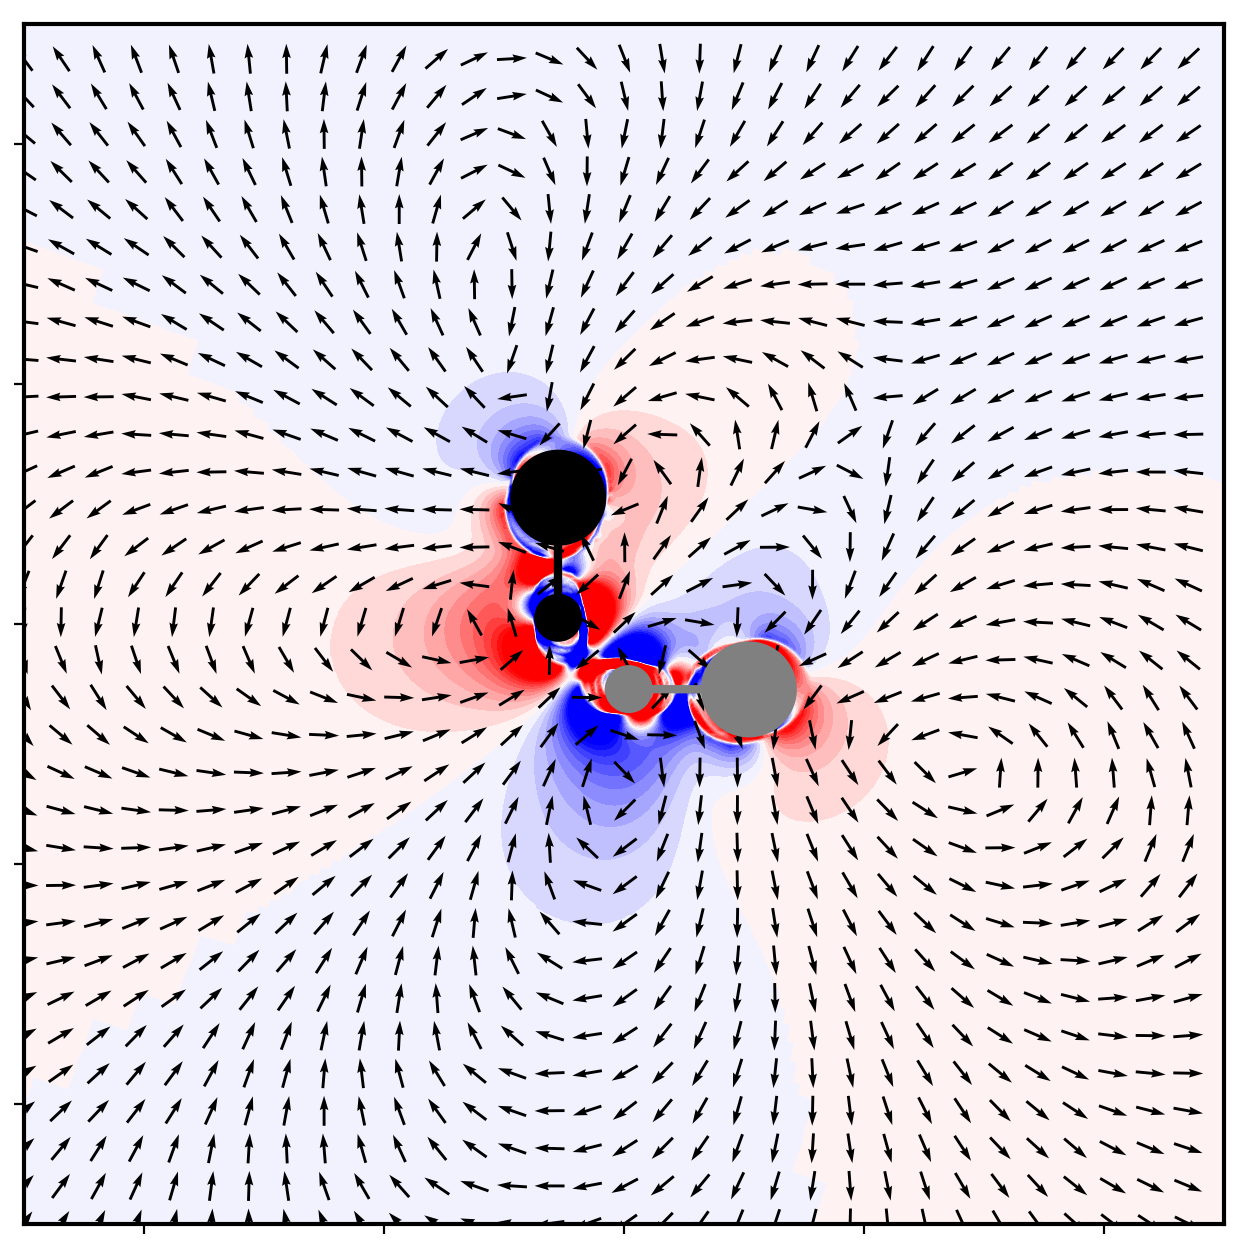

Time to run for 1 period = 67.44019s


In [4]:
#READ ALL AVG FILES IN A SIMULATION DIRECTORY
#EXTRACT AVERAGE FIELD DATA INTO NUMPY ARRAYS
#PLOT AVERAGED FIELD DATA
#Simulation Parameters
#simList = ['HB','SF','L','V']
cwd_Re = cwd_PYTHON+'../../FieldData/TestField/'
#Extract Position Data
cwd_POS = cwd_POS = cwd_PYTHON+'../../FieldData/TestField/'
#Calculate # Periods
DUMP_INT = 20.0
nTime = GetPosDataLength(cwd_POS)
nPer = int(np.trunc(1.0*nTime/DUMP_INT))
#nPer = 2
#Paths to data and plots
cwd_DATA = cwd_Re
countPer = 0
for countPer in range(nPer):
    if(countPer == perNumber):
        AVGPlot = pathlib.Path(cwd_DATA+'AVG_%04d.csv'%countPer)
        #if not AVGPlot.exists ():
        if AVGPlot.exists ():
            start = t.clock()
            #Get Avg Field Data
            mx,my,avgW,avgP,avgUx,avgUy = GetAvgFieldData(cwd_DATA,countPer)
            #Extract Position and Time Data
            time = np.round(0.05 + countPer*PERIOD,2)
            #print('time = ',time)
            posData = GetPosData(cwd_POS,time,config)
            #print(posData)
            #Plot Averaged Field Data
            #Vorticity And Streamlines
            pars = [Re,config,'W_stream',countPer]
            mx,my,avgUx,avgUy,posData = PlotCombinedStream(cwd_PYTHON,time,mx,my,avgW,avgUx,avgUy,posData,pars)
            #avgU = np.array([avgUx],[avgUy])
            stend = t.clock()
            diff = stend - start
            print('Time to run for 1 period = %.5fs'%diff)
            sys.stdout.flush()

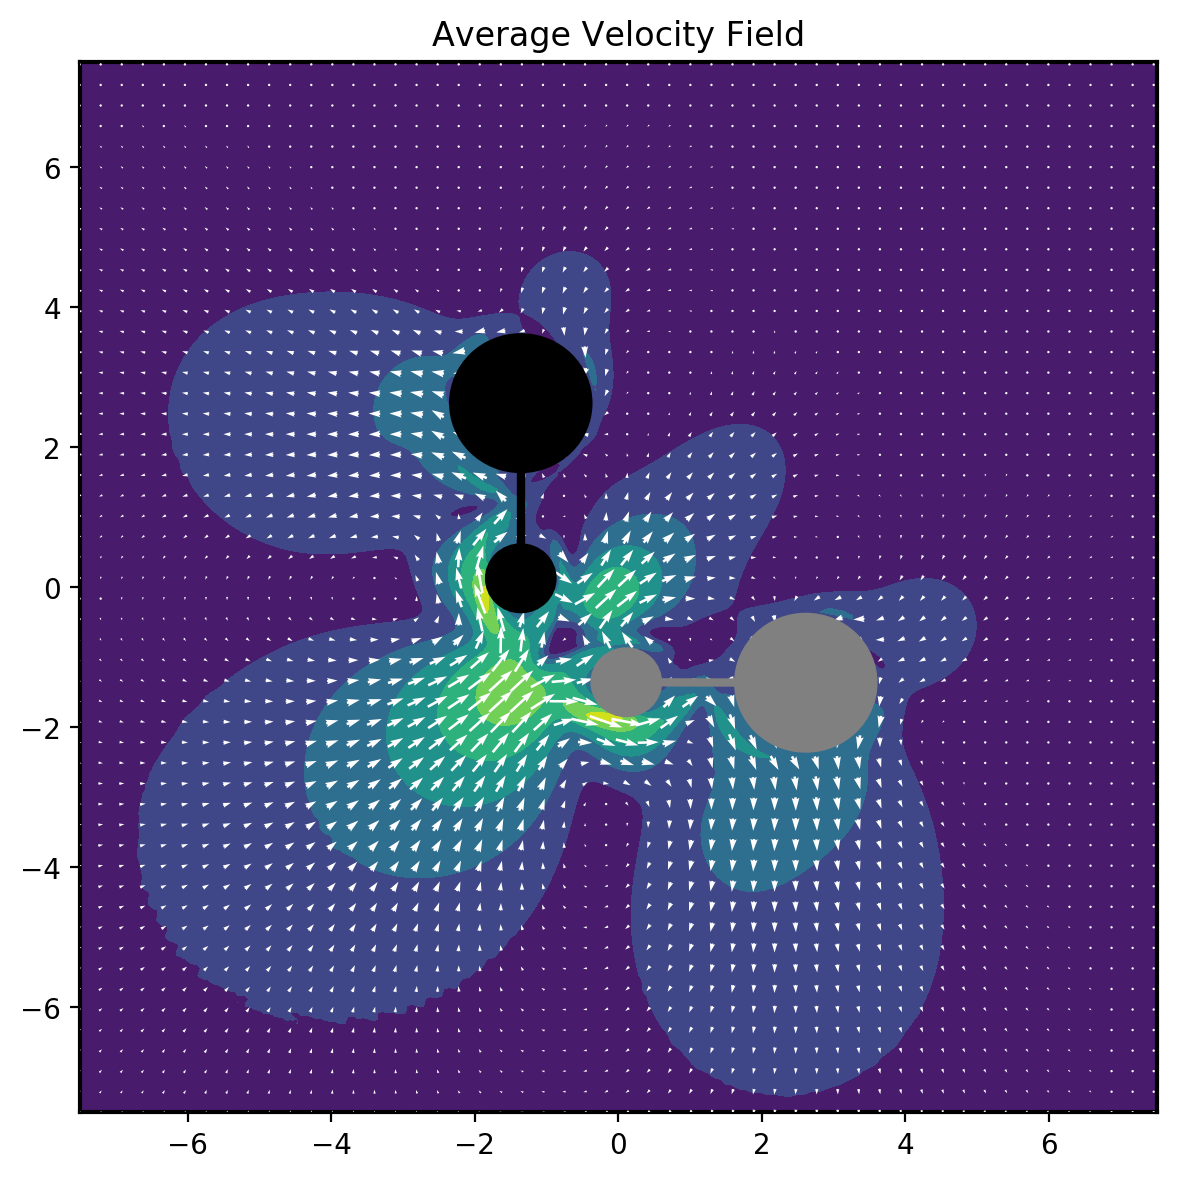

In [5]:
from matplotlib.patches import Circle

#Plot New mesh and interpolated velocity field Ux and Uy
def PlotAvgU(mx,my,Ux,Uy,pos,space):
    global FIGNUM, PERIOD
    #Here, we will visualize the velocity field on the new coordinate system
    nRows, nCols = 1, 1
    fig, ax = plt.subplots(nrows=nRows, ncols=nCols, num=FIGNUM,figsize=(6,6),dpi=200)
    ax.set_title(r'Average Velocity Field',fontsize=12)
    normUx,normUy = Ux/np.hypot(Ux,Uy),Uy/np.hypot(Ux,Uy)
    magU = np.hypot(Ux,Uy)
    #Plot Vector field with quiver
    #ax.quiver(mx[::space,::space],my[::space,::space],
    #          normUx[::space,::space],normUy[::space,::space],
    #          color='white',pivot='mid',scale=50,zorder=5)
    ax.quiver(mx[::space,::space],my[::space,::space],
              Ux[::space,::space],Uy[::space,::space],
              color='white',pivot='mid',angles='xy',scale_units='xy', scale=10,zorder=5)
    #Plot magnitude with contourf
    ax.contourf(mx,my,magU,cmap='viridis')
    
    AddDiscsToPlot(ax,pos)
    #print('RSMALL = ',RSMALL)
    ax.axis([-7.5,7.5,-7.5,7.5])
    fig.tight_layout()
    plt.show()
    fig.clf()
    FIGNUM += 1
    plt.close()
    return

#Visual Check of vel field's data (any idx)
PlotAvgU(mx,my,avgUx,avgUy,posData,6)

In [7]:
def InterpolateParticleVelocity(mx,my,Ux,Uy,coords):
    #mx,my: avg field mesh
    #Ux,Uy: avg velocity field
    #coords: particles coordinates where interpolation will take place
    #Interpolate Ux and Uy from original cartesian coordinates to new cartesian grid
    #Griddata
    #Can change method = 'linear','cubic','nearest' #(mx_new,my_new)
    partUx=interpolate.griddata((mx.flatten(),my.flatten()),Ux.flatten() , coords,method='cubic')
    partUy=interpolate.griddata((mx.flatten(),my.flatten()),Uy.flatten() , coords,method='cubic')

    print('Coordinate Transformation Complete!')
    return (partUx,partUy)

from matplotlib.patches import Circle

#Plot New mesh and interpolated velocity field Ux and Uy
def PlotParticles(mx,my,U,pos,particles,frame,strDir):
    global FIGNUM, PERIOD
    #Here, we will visualize the velocity field on the new coordinate system
    nRows, nCols = 1, 1
    fig, ax = plt.subplots(nrows=nRows, ncols=nCols, num=FIGNUM,figsize=(6,6),dpi=200)
    ax.set_title(r'Test Particles',fontsize=12)
    
    #ax.scatter(particles.x[0],particles.y[0],s=24,zorder=7,color='k')
    alpha = np.linspace(0.2,1.0,particles.nTime)
    for idTime in range(particles.nTime):
        pointColor = (1.0-(1.0*idTime/(1.0*nTime)),)*3
        alphaValue = alpha[idTime]
        markerSize = particles.size[idTime,0]
        #ax.scatter(particles.x[idTime].flatten(),particles.y[idTime].flatten(),s=particles.size[idTime].flatten(),
                   #color=pointColor,zorder=5,alpha=alphaValue)
        ax.plot(particles.x[idTime].flatten(),particles.y[idTime].flatten(),marker='o',ms=markerSize,
                   color=pointColor,zorder=5,alpha=1,linewidth=0)
    #ax.plot(particles.x.flatten(),particles.y.flatten(),
                   #color=pointColor,zorder=5,alpha=0.5)
    #ax.scatter(mx[particles.idy[0],particles.idx[0]],my[particles.idy[0],particles.idx[0]],s=48,color=(0.5,)*3)
    
    '''
    #Velocity Field
    Ux, Uy = U[0].copy(), U[1].copy()
    normUx,normUy = Ux/np.hypot(Ux,Uy),Uy/np.hypot(Ux,Uy)
    magU = np.hypot(Ux,Uy)
    #Plot Vector field with quiver
    space=2
    ax.quiver(mx[::space,::space],my[::space,::space],
              Ux[::space,::space],Uy[::space,::space],
              color='k',pivot='mid',angles='xy', scale_units='xy', scale=10,zorder=3)
    '''
    #Plot Swimmer
    AddDiscsToPlot(ax,pos)
    #print('RSMALL = ',RSMALL)
    ax.axis([-7.5,7.5,-7.5,7.5])
    fig.tight_layout()
    fig.savefig(strDir+'Test_{0}_.png'.format(frame))
    #plt.show()
    fig.clf()
    FIGNUM += 1
    plt.close()
    return


#Now that we have the abg velocity field, we can calculate particle trajectories
#Let's start with 10
# Initialize 10 random coordinates
# Each coordinate will have a lifetime from 60 -> 240 frames
# For each, calculate the new position based on the velocity field (do this for twenty timesteps)
# The velocity field does not evolve
# Create array of points (use interpolate.griddata to find velocities)
# pos += dt*velocity_interp
# Plot scatter which decreases in opacity and point size for timesteps going backward
# Advance time for each new frame

class Particles:
    def __init__(self,rows,cols,minVal,maxVal,nPart,nTime):
        self.nPart = nPart
        self.nTime = nTime
        xvals = np.linspace(minVal,maxVal,rows)
        yvals = np.linspace(minVal,maxVal,cols)
        mx, my = np.meshgrid(xvals,yvals)
        self.x  = np.array([mx.flatten()]*nTime).reshape((nTime,nPart))
        self.y  = np.array([my.flatten()]*nTime).reshape((nTime,nPart))
        self.xinit = self.x.copy()
        self.yinit = self.y.copy()
        self.vx  = np.zeros((nTime,nPart))
        self.vy  = np.zeros((nTime,nPart))
        self.vxinit = self.vx.copy()
        self.vyinit = self.vy.copy()
        self.idx = np.array([[int((self.x[a,b] + maxR)/dX) for b in range(self.nPart)] for a in range(self.nTime)])
        self.idy = np.array([[int((self.y[a,b] + maxR)/dX) for b in range(self.nPart)] for a in range(self.nTime)])
        self.age  = np.array([random.randrange(10,240) for b in range(nPart)]*nTime).reshape((nTime,nPart))
        self.life = self.age.copy()
        self.size = np.array([np.linspace(0.001,.1,self.nTime) for a in range(self.nPart)]).T.reshape((nTime,nPart))
        self.curr_age  = np.zeros((nTime,nPart))
    def CalcMeshIndex(self,idTime):
        self.idx[idTime] = [int((self.x[idTime,b] + maxR)/dX) for b in range(self.nPart)]
        self.idy[idTime] = [int((self.y[idTime,b] + maxR)/dX) for b in range(self.nPart)]
        #print('idx = ',self.idx[idTime])
        #print('idy = ',self.idy[idTime])
    def AssignVelocity(self,idTime,nX,avgUx,avgUy):
        indices = nX*self.idy[idTime]+self.idx[idTime]
        self.vx[idTime] = avgUx[indices]
        self.vy[idTime] = avgUy[indices]
        #print('vx = ',self.vx[idTime])
        #print('vy = ',self.vy[idTime])
        
    

#Initialize 10 random points. The structure should be a 2D ndarray
#Choose points in range (-5,5) for both x and y
nFrames = 240
minVal, maxVal = -7.45,7.45
rows, cols = 60, 60
nPart, nTime = rows*cols, 60
timestep = 0.2/60.0
dX = 2.0*maxR/(1.0*NX)
seed = random.seed(11235)
strDir = cwd_PYTHON+"../../Figures/ParticleStreamline/TestField/"
pathlib.Path(strDir).mkdir(parents=True, exist_ok=True)
#Flatten avg Velocity field
#print(avgU[1,281,248])
avgU = np.array([[avgUx],[avgUy]])
avgUx = avgUx.flatten()
avgUy = avgUy.flatten()
magU = np.hypot(avgUx,avgUy)
print('dX = ',dX)
print('max dX = ',timestep*np.amax(magU))
assert dX >= np.amax(magU)*timestep
#print(avgUx[NX*248+281])
#print(avgUy[NX*248+281])
particles = Particles(rows,cols,minVal,maxVal,nPart,nTime)
#print(particles.age)
# Now we need to find the interpolated velocity for the starting positions
#coords = np.array([particles.x[0],particles.y[0]]).T
#print(coords)
#Interpolate Velocity
#partUx, partUy = InterpolateParticleVelocity(mx,my,avgU[0],avgU[1],coords)
#print(partUx)

#Initialize Particles
#Find velocity by index value (no interpolation)
for idTime in range(nTime):
    #Calculate Mesh Index for idTime
    particles.CalcMeshIndex(idTime)
    #print('x = ',particles.x[idTime])
    #print('y = ',particles.y[idTime])
    #Assign velocity by index (no interp)
    particles.AssignVelocity(idTime,NX,avgUx,avgUy)
    #Update position idTime+1
    if idTime < nTime - 1:
        changeX = timestep*particles.vx[idTime]
        changeY = timestep*particles.vy[idTime]
        #print('changeX = ',changeX)
        #print('changeY = ',changeY)
        particles.x[idTime+1:nTime] += changeX
        particles.y[idTime+1:nTime] += changeY
        #Increase age of particles
        particles.curr_age[:idTime+1] -= 1
#Save Initial particle stream pos and vel
particles.xinit = particles.x[0,:].copy()#particles.x.copy()
particles.yinit = particles.y[0,:].copy()#particles.y.copy()
particles.vxinit = particles.vx[0,:].copy()#particles.vx.copy()
particles.vyinit = particles.vy[0,:].copy()#particles.vy.copy()


print('B4')
print('life[100] = ',particles.age[:,100])
print('curr_age[100] = ',particles.curr_age[:,100])
print('x[100] = ',particles.x[:,100])
print('y[100] = ',particles.y[:,100])
print('vx[100] = ',particles.vx[:,100])
print('vy[100] = ',particles.vy[:,100])
sys.exit(0)

#Loop over # of frames
for idxFrame in range(2*nFrames):
    
    #Check Age
    particles.x = np.where(particles.curr_age >= particles.age, particles.xinit, particles.x)
    particles.y = np.where(particles.curr_age >= particles.age, particles.yinit, particles.y)
    particles.vx = np.where(particles.curr_age >= particles.age, particles.vxinit, particles.vx)
    particles.vy = np.where(particles.curr_age >= particles.age, particles.vyinit, particles.vy)
    particles.age = np.where(particles.curr_age >= particles.age, nFrames, particles.age)
    particles.curr_age = np.where(particles.curr_age >= particles.life, 0, particles.curr_age)
    particles.life = particles.age.copy()
    
    #Plot Particle Stream
    if idxFrame >= nFrames:
        PlotParticles(mx,my,avgU,posData,particles,idxFrame-nFrames,strDir)
    #Increase particle age
    particles.curr_age += 1
    #Roll positions and velocities back 1. Will need to calculate last position each particle
    #print('y = ',particles.y[:,1])
    particles.x = np.roll(particles.x,-1,axis=0)
    particles.y = np.roll(particles.y,-1,axis=0)
    #print('y = ',particles.y[:,1])
    particles.vx = np.roll(particles.vx,-1,axis=0)
    particles.vy = np.roll(particles.vy,-1,axis=0)
    #print('vy = ',particles.vy[:,1])
    #Change Position of last value by using velocity of 2nd to last
    changeX = timestep*particles.vx[-2]
    #print('vy[-2,1] = ',particles.vy[-2,1])
    changeY = timestep*particles.vy[-2]
    #print('changeY = ',changeY[1])
    particles.x[-1] = particles.x[-2] + changeX
    particles.y[-1] = particles.y[-2] + changeY
    #Update Mesh Index
    particles.CalcMeshIndex(-1)
    #Update Velocity of first particle in trail
    particles.AssignVelocity(-1,NX,avgUx,avgUy)
    #print('y = ',particles.y[:,1])
    #sys.exit(0)
    '''
    if idxFrame == 350:
        print('A4')
        print('life[100] = ',particles.age[:,100])
        print('curr_age[100] = ',particles.curr_age[:,100])
        print('vx[100] = ',particles.vx[:,100])
        print('vy[100] = ',particles.vy[:,100])
        print('x[100] = ',particles.x[:,100])
        print('y[100] = ',particles.y[:,100])
        sys.exit(0)
    '''
    
    if idxFrame %60 == 0:
        print('Frame {0} is complete'.format(idxFrame))

os.chdir(cwd_PYTHON+"../../Figures/ParticleStreamline/TestField/")
os.system("ffmpeg -r 60 -i Test_%d_.png -vcodec libx264 -pix_fmt yuv420p -y TestPair.mp4")
os.system("rm -rf Test_*")
os.chdir(cwd_PYTHON)
print('Test Movie is complete')

dX =  0.048828125
max dX =  0.01763360436193833
B4
life[100] =  [92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92
 92 92 92 92 92 92 92 92 92 92 92 92]
curr_age[100] =  [-59. -58. -57. -56. -55. -54. -53. -52. -51. -50. -49. -48. -47. -46.
 -45. -44. -43. -42. -41. -40. -39. -38. -37. -36. -35. -34. -33. -32.
 -31. -30. -29. -28. -27. -26. -25. -24. -23. -22. -21. -20. -19. -18.
 -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.
  -3.  -2.  -1.   0.]
x[100] =  [2.65169492 2.65160899 2.65152307 2.65143715 2.65135123 2.65126531
 2.65117938 2.65109346 2.65100754 2.65092162 2.6508357  2.65074977
 2.65065747 2.65056517 2.65047287 2.65038056 2.65028826 2.65019596
 2.65010365 2.65001135 2.64991905 2.64982674 2.64973444 2.64964214
 2.64954984 2.64945753 2.64936523 2.64927293 2.64918062 2.64908832
 2.64899602 2.64889301 2.64878999 2.64868698 2.64858397 2.64848096
 2.64837795 2.648

SystemExit: 0

/Users/thomas/anaconda3/envs/tf-research/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
